#  Anomaly detection using an LSTM Auto-encoder 

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from keras.models import Model,Sequential
from keras.layers import LSTM, Input, Dropout,Dense,RepeatVector,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
#df_org = pd.read_csv('/kaggle/input/fordstocks/FORD.csv')
df_org = pd.read_csv('FORD.csv')
df_org.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
12302,2021-03-15,13.39,13.62,13.05,13.20,13.20,64476000
12303,2021-03-16,13.06,13.15,12.43,12.49,12.49,124964700
12304,2021-03-17,12.34,12.70,12.22,12.69,12.69,108688100
12305,2021-03-18,12.70,13.01,12.44,12.49,12.49,76619600
12306,2021-03-19,12.85,12.95,12.55,12.83,12.83,89785500


In [4]:
df = df_org[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Close
0,1972-06-01,2.153220
1,1972-06-02,2.149165
2,1972-06-05,2.149165
3,1972-06-06,2.124835
4,1972-06-07,2.112670


In [5]:
print("Start date: ", df['Date'].min())
print("End date: ", df['Date'].max())

Start date:  1972-06-01 00:00:00
End date:  2021-03-19 00:00:00


<AxesSubplot:xlabel='Date', ylabel='Close'>

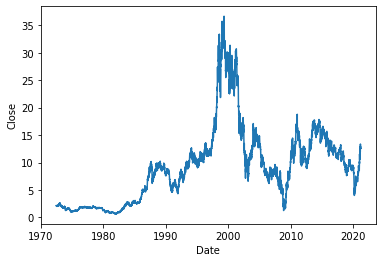

In [7]:
%matplotlib inline
sns.lineplot(x=df['Date'], y=df['Close'])


In [6]:
#Split data into train and test
train, test = df.loc[df['Date'] <= '2010-12-31'], df.loc[df['Date'] > '2010-12-31']

### Visualize the Train and Test datasets

<AxesSubplot:xlabel='Date', ylabel='Close'>

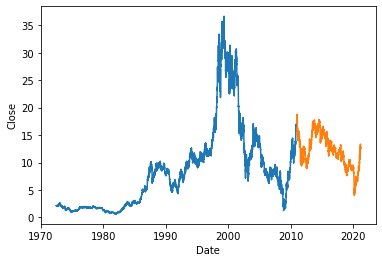

In [8]:
sns.lineplot(x=train['Date'], y=train['Close'])
sns.lineplot(x=test['Date'], y=test['Close'])

## Normalizing the dataset: 

LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized

Standard scaler scales the features by removing the mean and scaling to unit variance

In [9]:
scaler = StandardScaler()  
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [11]:

seq_size = 90  # Number of time steps to look back 

#Larger sequences (looking further back) may improve forecasting.


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

In [12]:
trainX, trainY = to_sequences(train[['Close']], train['Close'], seq_size)
testX, testY = to_sequences(test[['Close']], test['Close'], seq_size)

## Define the Model

In [13]:
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=False))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 90, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
____________________________________________________

In [ ]:
# fit model
history = model.fit(trainX, trainY, epochs=1000, batch_size=256, validation_split=0.1, verbose=1,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')])

## Loss Plots:

Use early stopping instead of training for a fixed set of epochs.

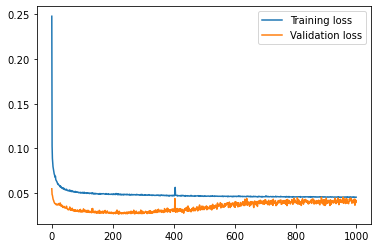

In [15]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

## Detecting anomalies:
Anomaly occurs where the reconstruction error is large (above a certain threshold).
We can define this value beyond which we ascertain an anomaly.

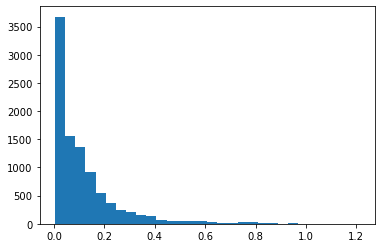

In [35]:
'''
MAE in training prediction
'''
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 0.25*np.max(trainMAE)  # 25% of the MAE

(array([ 96., 186., 276., 260., 274., 207., 175., 187., 175., 132.,  99.,
         81.,  71.,  49.,  29.,  29.,  28.,  26.,  22.,  15.,  17.,  10.,
         10.,   6.,   6.,   9.,   3.,   0.,   1.,   1.]),
 array([0.0253189 , 0.04370245, 0.06208599, 0.08046953, 0.09885307,
        0.11723661, 0.13562016, 0.1540037 , 0.17238724, 0.19077078,
        0.20915432, 0.22753787, 0.24592141, 0.26430495, 0.28268849,
        0.30107203, 0.31945558, 0.33783912, 0.35622266, 0.3746062 ,
        0.39298974, 0.41137329, 0.42975683, 0.44814037, 0.46652391,
        0.48490745, 0.503291  , 0.52167454, 0.54005808, 0.55844162,
        0.57682516]),
 <BarContainer object of 30 artists>)

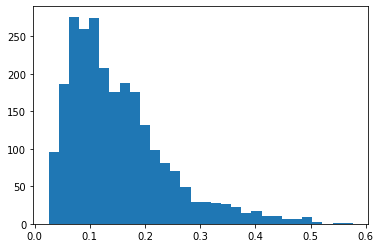

In [36]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

<AxesSubplot:xlabel='Date', ylabel='testMAE'>

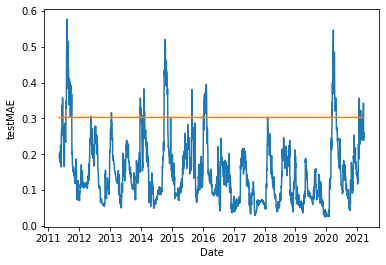

In [38]:
#Store the variables in a DataFrame for plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

## Detected Anomalies:

<AxesSubplot:xlabel='Date'>

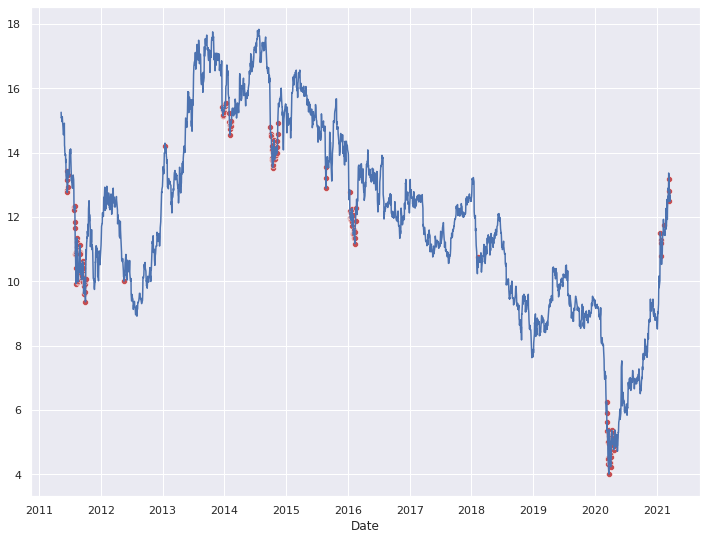

In [41]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
sns.set(rc={'figure.figsize':(12,9)})
#Plot anomalies
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close']))  #The inverse_transform applies the "inverse" of scaling operation in "inverse" order
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), color='r')
